# Análisis de sentimientos, afecto y connotación
**Gabriella Bollici**

El presente trabajo constituye un intento de análisis de la emoción utilizando el enfoque del aprendizaje automático tradicional, incluyendo fase de preparación y preprocesamiento de los datos, fase de entrenamiento, fase de evaluación, y fase de exploración e interpretación de los resultados obtenidos. Emplearé el clasificador de los k vecinos más cercanos y máquinas de vectores de soporte lineales para realizar el análisis de afecto del dataset de Emotion de Huggingface en inglés.

El primer paso es cargar el dataset.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece] sacrebleu -Uq

from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("n6L3/emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

El dataset ya está dividido en validación, entrenamiento y test, solo hay que crear una columna split donde se refleje esta división y unir los datos en un dataframe.

In [ ]:
import pandas as pd
from datasets import load_dataset

# cargar los datos de cada set
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

# crear una columna para cada set
train_data = train_data.add_column('split', ['train'] * len(train_data))
val_data = val_data.add_column('split', ['validation'] * len(val_data))
test_data = test_data.add_column('split', ['test'] * len(test_data))

# unir los datos en un solo dataframe
import pandas as pd
df = pd.concat([train_data.to_pandas(), val_data.to_pandas(), test_data.to_pandas()])

Visualizamos el dataframe resultante. 

In [ ]:
df

,text,label,split
0,i didnt feel humiliated,0,train
1,i can go from feeling so hopeless to so damned...,0,train
2,im grabbing a minute to post i feel greedy wrong,3,train
3,i am ever feeling nostalgic about the fireplac...,2,train
4,i am feeling grouchy,3,train
...,...,...,...
1995,i just keep feeling like someone is being unki...,3,test
1996,im feeling a little cranky negative after this...,3,test
1997,i feel that i am useful to my people and that ...,1,test
1998,im feeling more comfortable with derby i feel ...,1,test


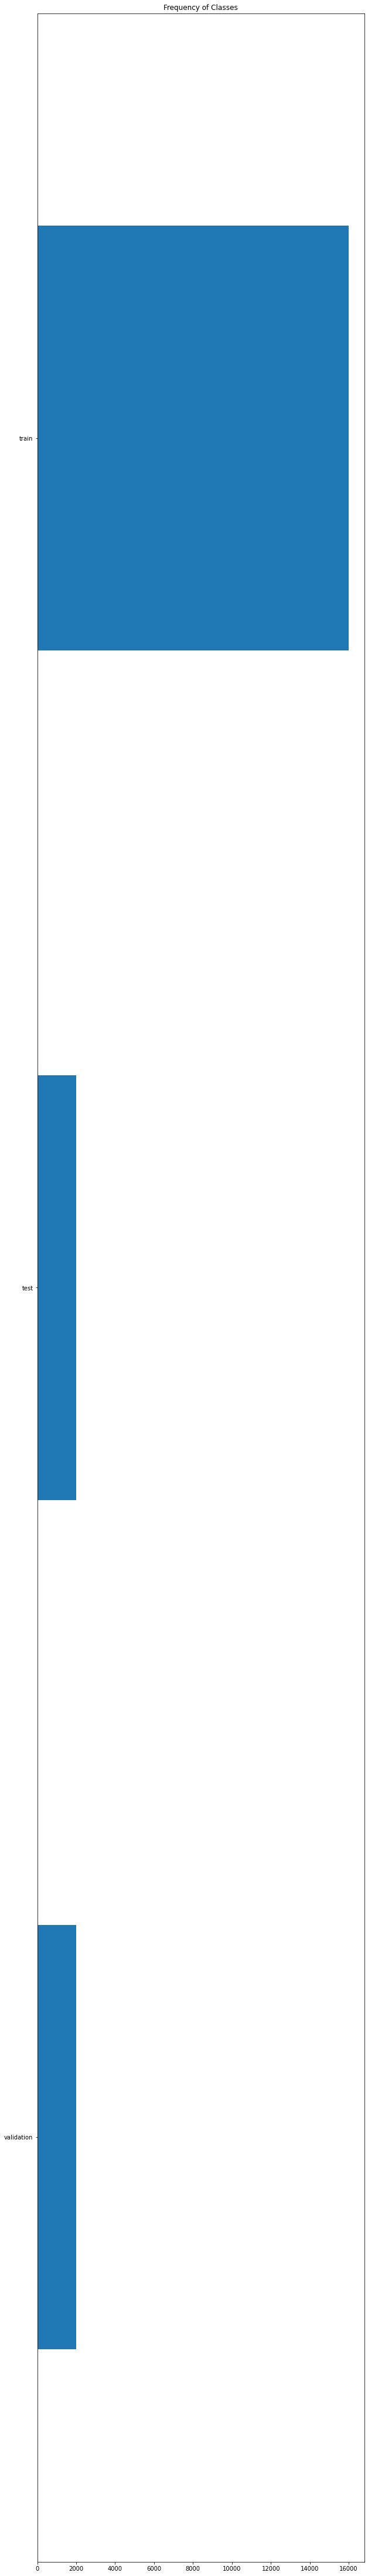

In [ ]:
# Distribución de instancias por split

import matplotlib.pyplot as plt

df["split"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

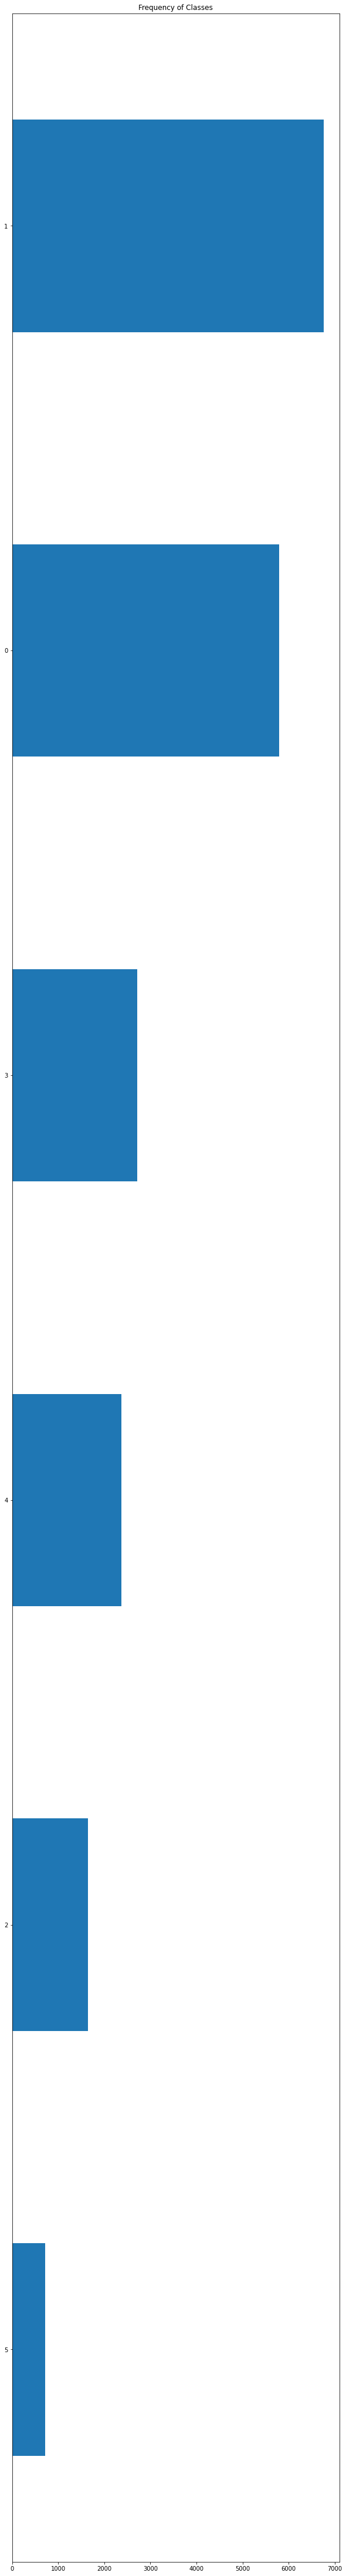

In [ ]:
# Distribucion de instancias por clases (i.e. emociones): dataset desequilibrado

df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

Dado que el texto del dataset no contiene mucho ruido, no es necesario limpiarlo. Pasamos a vectorizar el texto empleando CountVectorizer, del que ya hablamos en el Notebook anterior. Básicamente crea un objeto que se puede utilizar para convertir un conjunto de textos en una matriz de características numéricas

In [ ]:
# Utilizamos las stopwords en inglés para CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
english_stopwords = stopwords.words('english')
english_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Utilizamos el tokenizador para inglés de NLTK para CountVectorizer
def spanish_tokenizer(text):
  tokenized_text = nltk.word_tokenize(text, language='english')
  return tokenized_text

cv = CountVectorizer(stop_words=english_stopwords,ngram_range = (1,3),tokenizer = spanish_tokenizer)

A continuación, paso a convertir los textos en matrices de cuentas de tokens. Pero primero se divide el dataframe en tres, uno por split, y se aleatorizan los conjuntos de datos, que estaban ordenados.


In [ ]:
import random
random.seed(0)

df_train = df[df['split'] == 'train']
df_valid = df[df['split'] == 'validation']
df_test = df[df['split'] == 'test']

df_train = df_train.sample(frac=1)
df_valid = df_valid.sample(frac=1)
df_test = df_test.sample(frac=1)

df_train

,text,label,split
15844,i try to stay with my feelings caring for them...,2,train
3550,i longed for that feeling i once knew the feel...,2,train
5999,i feel like wow that s very cool that could be me,1,train
15794,i feel that i am too distracted to do well on ...,3,train
4882,i feel like the apothecary in romeo and juliet...,0,train
...,...,...,...
4970,i feel like ive hated on this series a lot sin...,0,train
11074,i began to feel that it was shaken so badly th...,4,train
8582,im feeling a bit mellow this morning,1,train
1238,i feel so highly intimidated that i get fluste...,4,train


En la primera línea se utiliza CountVectorizer para convertir el texto en la columna 'text' del dataframe de entrenamiento df_train en una matriz de cuentas de tokens, y se ajustan los parámetros del vectorizador en función del texto del conjunto de entrenamiento. La segunda línea utiliza CountVectorizer para convertir el texto de 'text' del dataframe de validación df_test en una matriz de cuentas de tokens, pero sin ajustar los parámetros del vectorizador, solo utilizando los parámetros ajustados previamente en el conjunto de entrenamiento. La tercera línea, es similar a la segunda, pero utilizando el texto del conjunto de evaluación en lugar del conjunto de validación. Estas líneas preparan los datos de texto para ser procesados por el clasificador. Las últimas tres líneas de código convierten las etiquetas en una matriz de etiquetas para su procesamiento por parte del clasificador.

In [ ]:
X_train = cv.fit_transform(df_train['text'])
X_valid = cv.transform(df_valid['text'])
X_test = cv.transform(df_test['text'])

y_train = df_train["label"]
y_valid = df_valid["label"]
y_test = df_test["label"]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


Buscamos los mejores hiperparámetros.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Crea el clasificador KNN
knn = KNeighborsClassifier()

# Crea el grid de parámetros a probar
param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              }

# Crea el objeto de búsqueda de hiperparámetros
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Entrena el modelo utilizando el dataset de entrenamiento y el grid de hiperparámetros
grid_search.fit(X_train, y_train)

# Imprime los mejores hiperparámetros encontrados
print(grid_search.best_params_)

# Evalúa los hiperparámetros en el dataset de validación
val_score = grid_search.score(X_valid, y_valid)
print("Validation accuracy:", val_score)

{'n_neighbors': 5, 'weights': 'distance'}
Validation accuracy: 0.56


Importamos las librerías: GridSearchCV, para búsqueda de hiperparámetros, y KNeighborsClassifier, el modelo de clasificación. Después creamos un objeto de la clase KNeighborsClassifier, el clasificador KNN, y definimos un diccionario de parámetros que se quieren probar: diferentes valores de k (número de vecinos más cercanos a considerar) y diferentes tipos de pesos (uniforme o por distancia). Luego, se crea un objeto de la clase GridSearchCV, que recibe como parámetros el clasificador KNN y el grid de hiperparámetros. El parámetro cv=5 indica que se va a utilizar validación cruzada de tipo K-fold con K=5. Para el entrenamiento del modelo, llamamos al método fit del objeto grid_search y se le proporciona el dataset de entrenamiento. De esta forma, el modelo entrena con todas las combinaciones posibles de hiperparámetros y valida los resultados con el dataset de validación. Finalmente se imprimen los hiperparámetros con el mejor resultado de validación y se calcula y se imprime la precisión del modelo con el dataset de validación.

In [ ]:
knn_best = KNeighborsClassifier(**grid_search.best_params_)
knn_best.fit(X_train, y_train)  # entrenamos el modelo con el conjunto de entrenamiento

test_score = knn_best.score(X_test, y_test) # resultado
print("Test accuracy:", test_score)

Test accuracy: 0.5745


Evaluamos el macro-F1 y el F1 ponderado, así como la precisión, cobertura y F1 de cada clase.

In [ ]:
from sklearn.metrics import classification_report

y_pred = knn_best.predict(X_test) # hacemos predicciones con el conjunto de evaluación
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.54      0.72      0.62       581
           1       0.66      0.61      0.63       695
           2       0.57      0.25      0.35       159
           3       0.46      0.52      0.49       275
           4       0.65      0.49      0.56       224
           5       0.45      0.20      0.27        66

    accuracy                           0.57      2000
   macro avg       0.55      0.47      0.49      2000
weighted avg       0.58      0.57      0.57      2000



Ahora voy a probar TfidfVectorizer empleando las mismas características para ver si obtenemos mejores resultados. TfidfVectorizer es otro vectorizador que se basa en la frecuencia de términos (Term Frequency, TF). En CountVectorizer un documento con alta frecuencia recibirá el mismo peso, independientemente de la longitud del documento, mientras que TfidfVectorizer da más peso a términos que son importantes para un documento en particular y menos peso a términos comunes en todos los documentos

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=english_stopwords,ngram_range = (1,3),tokenizer = spanish_tokenizer)

X_train = tfidf.fit_transform(df_train['text'])
X_valid = tfidf.transform(df_valid['text'])
X_test = tfidf.transform(df_test['text'])

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [ ]:
knn_best = KNeighborsClassifier(**grid_search.best_params_)
knn_best.fit(X_train, y_train)  # entrenamos el modelo con el conjunto de entrenamiento

test_score = knn_best.score(X_test, y_test) # resultado
print("Test accuracy:", test_score)

Test accuracy: 0.7605


In [ ]:
from sklearn.metrics import classification_report

y_pred = knn_best.predict(X_test) # hacemos predicciones con el conjunto de evaluación
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       581
           1       0.80      0.82      0.81       695
           2       0.66      0.54      0.60       159
           3       0.73      0.70      0.72       275
           4       0.76      0.68      0.72       224
           5       0.66      0.47      0.55        66

    accuracy                           0.76      2000
   macro avg       0.73      0.68      0.70      2000
weighted avg       0.76      0.76      0.76      2000



In [ ]:
df_test['kNN_predictions'] = y_pred
df_test

,text,label,split,kNN_predictions
1244,i feel they are one of the most talented teams...,1,test,1
946,i feel rejected and i cant find what ive left ...,0,test,0
808,i can t say for certain why but it actually ma...,1,test,1
1140,i feel so totally invigorated that i completel...,1,test,0
1896,i have been feeling a little or a lot lost,0,test,0
...,...,...,...,...
260,i used to be able to hang around talk with the...,3,test,3
688,i feel hated in cempaka,0,test,3
1583,i am not feeling so generous and he is sent to...,1,test,1
539,i feel annoyingly isolated in the hostel with ...,0,test,4


El clasificador KNN no produce valores de pérdida en el sentido tradicional, sino que se basa en la métrica de distancia para determinar la clase de una muestra dada.

Ahora el modelo a entrenar es un clasificador de árboles de decisión, un tipo de algoritmo de aprendizaje automático que toma decisiones basadas en el análisis de reglas derivadas de un conjunto de datos de entrenamiento.


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Creamos el clasificador de árboles de decisión
tree_clf = DecisionTreeClassifier()

# Creamos el grid de parámetros a probar
param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 3, 4, 5]
              }

# Creamos el objeto de búsqueda de hiperparámetros
grid_search = GridSearchCV(tree_clf, param_grid, cv=5)

# Entrenamos el modelo utilizando el dataset de entrenamiento y el grid de hiperparámetros
grid_search.fit(X_train, y_train)

# Imprimimos los mejores hiperparámetros encontrados
print(grid_search.best_params_)

# Calculamos la precisión del modelo en el conjunto de validación
val_score = grid_search.score(X_valid, y_valid)
print("Validation accuracy:", val_score)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}
Validation accuracy: 0.3855


In [ ]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)  # entrenamos el modelo con el conjunto de entrenamiento

test_score = tree_clf.score(X_test, y_test) # resultado
print("Test accuracy:", test_score)

Test accuracy: 0.875


In [ ]:
y_pred = tree_clf.predict(X_test) # hacemos predicciones con el conjunto de evaluación
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       581
           1       0.92      0.88      0.90       695
           2       0.72      0.74      0.73       159
           3       0.86      0.92      0.89       275
           4       0.83      0.84      0.84       224
           5       0.65      0.71      0.68        66

    accuracy                           0.88      2000
   macro avg       0.82      0.84      0.83      2000
weighted avg       0.88      0.88      0.88      2000



In [ ]:
df_test['DT_predictions'] = y_pred
df_test

,text,label,split,kNN_predictions,DT_predictions
1244,i feel they are one of the most talented teams...,1,test,1,1
946,i feel rejected and i cant find what ive left ...,0,test,0,0
808,i can t say for certain why but it actually ma...,1,test,1,1
1140,i feel so totally invigorated that i completel...,1,test,0,3
1896,i have been feeling a little or a lot lost,0,test,0,0
...,...,...,...,...,...
260,i used to be able to hang around talk with the...,3,test,3,3
688,i feel hated in cempaka,0,test,3,3
1583,i am not feeling so generous and he is sent to...,1,test,1,1
539,i feel annoyingly isolated in the hostel with ...,0,test,4,0


In [ ]:
probs = tree_clf.predict_proba(X_test)
# Obtiene la probabilidad de cada predicción hecha por el modelo
probs

array([[0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [ ]:
from sklearn.metrics import log_loss
import numpy as np

emotions = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
losses = []
for true_label, predicted_probs in zip(y_test, probs):
    # Convertimos la etiqueta real a un formato compatible con log_loss
    true_label_encoded_array = np.zeros(len(emotions))
    true_label_encoded_array[true_label] = 1
    # Calculamos el valor de pérdida para esta instancia
    loss = log_loss(true_label_encoded_array, predicted_probs)
    losses.append(loss)
losses

[2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 12.014551129705717,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 12.014551129705717,
 12.014551129705717,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 12.014551129705717,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503136e-16,
 2.2204460492503

In [ ]:
df_test['loss_values_DT'] = losses 
df_test

,text,label,split,kNN_predictions,DT_predictions,loss_values_DT
1244,i feel they are one of the most talented teams...,1,test,1,1,2.220446e-16
946,i feel rejected and i cant find what ive left ...,0,test,0,0,2.220446e-16
808,i can t say for certain why but it actually ma...,1,test,1,1,2.220446e-16
1140,i feel so totally invigorated that i completel...,1,test,0,3,1.201455e+01
1896,i have been feeling a little or a lot lost,0,test,0,0,2.220446e-16
...,...,...,...,...,...,...
260,i used to be able to hang around talk with the...,3,test,3,3,2.220446e-16
688,i feel hated in cempaka,0,test,3,3,1.201455e+01
1583,i am not feeling so generous and he is sent to...,1,test,1,1,2.220446e-16
539,i feel annoyingly isolated in the hostel with ...,0,test,4,0,2.220446e-16


##Clasificador de máquina de soportes lineal.
Ahora vamos a utilizar el clasificador de máquina de vectores de soporte lineal haciendo una búsqueda de los mejores hiperparámetros. La línea param_grid = {'C': [0.1, 1, 10]}, crea un diccionario que define el conjunto de hiperparámetros que se va a optimizar utilizando GridSearchCV. El diccionario solo tiene una clave, 'C', que corresponde al parámetro de regularización del modelo de SVM. El valor de esta clave es una lista de tres valores posibles para el parámetro C, [0.1, 1, 10]. Por tanto, GridSearchCV prueba tres valores diferentes para el parámetro C: 0.1, 1 y 10. La otra línea, grid_search = GridSearchCV(clf, param_grid, cv=5), crea una instancia de GridSearchCV y la almacena en la variable grid_search. Al crear la instancia, se le pasan tres argumentos: clf, el modelo que se va a optimizar, param_grid, el diccionario que define los hiperparámetros a optimizar y sus posibles valores, y cv, el número de veces que se va a dividir el conjunto de entrenamiento para validar los diferentes valores de los hiperparámetros. En este caso, se especifica que se va a utilizar una validación cruzada de k-fold con k=5.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

clf = LinearSVC()

Los dos asteriscos () en la línea clf = LinearSVC(grid_search.best_params_) indican que se está utilizando la sintaxis de desempaquetado de argumentos de palabra clave (keyword arguments). De este modo, se pasa un diccionario como argumentos de una función o método, con cada clave del diccionario convirtiéndose en un argumento y cada valor convirtiéndose en el valor de ese argumento. Por otro lado, grid_search.best_params_ es un diccionario que contiene los mejores hiperparámetros encontrados por GridSearchCV, y cuando se pasan como argumentos de la función SVC con la sintaxis de desempaquetado de argumentos de palabra clave, se crea una instancia de SVC con los mejores hiperparámetros encontrados. Por ejemplo, si grid_search.best_params_ es {'C': 1}, entonces la línea clf = LinearSVC(**grid_search.best_params_) equivale a clf = LinearSVC(C=1).

In [ ]:
clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8935


Muy buena precisión en la parte de test.

In [ ]:
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       581
           1       0.91      0.93      0.92       695
           2       0.77      0.79      0.78       159
           3       0.90      0.87      0.89       275
           4       0.88      0.84      0.86       224
           5       0.72      0.64      0.68        66

    accuracy                           0.89      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.89      0.89      0.89      2000



Los resultados del report de clasificación son también muy buenos para todas las clases.

Se añaden las predicciones hechas por el modelo al dataframe.

In [ ]:
df_test['SVM_predictions'] = y_pred
df_test

,text,label,split,kNN_predictions,DT_predictions,loss_values_DT,SVM_predictions
1244,i feel they are one of the most talented teams...,1,test,1,1,2.220446e-16,1
946,i feel rejected and i cant find what ive left ...,0,test,0,0,2.220446e-16,0
808,i can t say for certain why but it actually ma...,1,test,1,1,2.220446e-16,1
1140,i feel so totally invigorated that i completel...,1,test,0,3,1.201455e+01,3
1896,i have been feeling a little or a lot lost,0,test,0,0,2.220446e-16,0
...,...,...,...,...,...,...,...
260,i used to be able to hang around talk with the...,3,test,3,3,2.220446e-16,3
688,i feel hated in cempaka,0,test,3,3,1.201455e+01,3
1583,i am not feeling so generous and he is sent to...,1,test,1,1,2.220446e-16,1
539,i feel annoyingly isolated in the hostel with ...,0,test,4,0,2.220446e-16,0


Para concluir, vamos a ver las predicciones con su pérdida correspondiente. Los valores de pérdida en un modelo de SVM lineal son distancia entre el punto de predicción y el límite de decisión del modelo. Si la predicción es correcta, los puntos de predicción tienen que estar muy alejados del límite de decisión para ser clasificados de manera segura en la clase correcta. Si un punto de predicción está demasiado cerca del límite de decisión, significa que el modelo está "incierto" sobre la clase a la que debe asignarlo. Cuanto mayor sea el valor de pérdida, mayor será la confianza del modelo en la predicción correspondiente.

En la siguiente línea de código se obtiene el valor de pérdida de cada predicción realizada por el modelo de SVM lineal, basándose en el conjunto de evaluación. Primero se invoca el método decision_function del objeto clf, pasándole como argumento el conjunto de prueba X_test. Se devuelve una matriz con tantas filas como elementos haya en X_test y tantas columnas como clases haya en el conjunto de entrenamiento, donde cada elemento de la matriz representa la distancia de cada elemento de X_test con el límite de decisión correspondiente a cada clase.

Después, se seleccionan las filas de la matriz que corresponden a cada predicción realizada del modelo (que se encuentran en y_pred) con el índice range(len(y_pred)), una lista con todos los índices de las filas de la matriz. Luego se seleccionan las columnas de la matriz que corresponden a cada predicción del modelo (que se encuentran en y_pred). Se hace con el índice y_pred-1, que es una lista con todos los índices de las columnas de la matriz.

Por último, se devuelve una lista con todos los elementos de la matriz seleccionados con estos índices, que representa los valores de pérdida de cada predicción realizada por el modelo de SVM lineal en el conjunto de prueba.

In [ ]:
# Calculamos la distancia de cada predicción con el límite de decisión
emotions = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
y_pred_labels = [emotions[label] for label in y_pred]
y_pred_int = [emotions_inv[label] for label in y_pred_labels]
loss_values = clf.decision_function(X_test)[range(len(y_pred)), y_pred_int]
loss_values

array([0.09976601, 1.24803524, 1.10721945, ..., 0.26756944, 0.35823028,
       1.51343229])

In [ ]:
df_test['loss_values_SVM'] = loss_values
df_test

,text,label,split,kNN_predictions,DT_predictions,loss_values_DT,SVM_predictions,loss_values_SVM
1244,i feel they are one of the most talented teams...,1,test,1,1,2.220446e-16,1,0.099766
946,i feel rejected and i cant find what ive left ...,0,test,0,0,2.220446e-16,0,1.248035
808,i can t say for certain why but it actually ma...,1,test,1,1,2.220446e-16,1,1.107219
1140,i feel so totally invigorated that i completel...,1,test,0,3,1.201455e+01,3,0.158123
1896,i have been feeling a little or a lot lost,0,test,0,0,2.220446e-16,0,1.165206
...,...,...,...,...,...,...,...,...
260,i used to be able to hang around talk with the...,3,test,3,3,2.220446e-16,3,0.651449
688,i feel hated in cempaka,0,test,3,3,1.201455e+01,3,1.120696
1583,i am not feeling so generous and he is sent to...,1,test,1,1,2.220446e-16,1,0.267569
539,i feel annoyingly isolated in the hostel with ...,0,test,4,0,2.220446e-16,0,0.358230


In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()

param_grid = {'alpha': [0.1, 1, 10]}
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
val_score = grid_search.score(X_valid, y_valid)
print("Validation accuracy:", val_score)

Best hyperparameters: {'alpha': 0.1}
Validation accuracy: 0.739


In [ ]:
clf = MultinomialNB(alpha=val_score)

clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.6755


In [ ]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.72      0.93      0.81       581
           1       0.61      1.00      0.76       695
           2       1.00      0.04      0.07       159
           3       0.95      0.21      0.35       275
           4       0.92      0.25      0.39       224
           5       0.00      0.00      0.00        66

    accuracy                           0.68      2000
   macro avg       0.70      0.40      0.40      2000
weighted avg       0.74      0.68      0.60      2000



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Para terminar, voy a añadir los nombres de las emociones al dataset final para que sea más ilustrativo.

In [ ]:
emotions = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
df_test['emotions'] = df_test['label'].map(emotions)
df_test

,text,label,split,kNN_predictions,DT_predictions,loss_values_DT,SVM_predictions,loss_values_SVM,emotions
1244,i feel they are one of the most talented teams...,1,test,1,1,2.220446e-16,1,0.099766,joy
946,i feel rejected and i cant find what ive left ...,0,test,0,0,2.220446e-16,0,1.248035,sadness
808,i can t say for certain why but it actually ma...,1,test,1,1,2.220446e-16,1,1.107219,joy
1140,i feel so totally invigorated that i completel...,1,test,0,3,1.201455e+01,3,0.158123,joy
1896,i have been feeling a little or a lot lost,0,test,0,0,2.220446e-16,0,1.165206,sadness
...,...,...,...,...,...,...,...,...,...
260,i used to be able to hang around talk with the...,3,test,3,3,2.220446e-16,3,0.651449,anger
688,i feel hated in cempaka,0,test,3,3,1.201455e+01,3,1.120696,sadness
1583,i am not feeling so generous and he is sent to...,1,test,1,1,2.220446e-16,1,0.267569,joy
539,i feel annoyingly isolated in the hostel with ...,0,test,4,0,2.220446e-16,0,0.358230,sadness


##Conclusión final

Los valores de predición que hemos obtenido con el clasificador de máquina de soportes lineal son muy altos, y la buena precisión del modelo también puede observarse en el dataframe resultante, que muestra predicciones acertadas de prácticamente todos los valores que se muestran. Otra buena señal de que los resultados son buenos es que los valores de pérdida son extremadamente bajos. A pesar de que los datos estaban desbalanceados, el modelo se ajusta muy bien a los datos. 

